In [1]:
%load_ext autoreload
%autoreload 2

# Simple example CBPS using Lalonde

In [2]:
import sys
sys.path.append("..")

import torch
from src.cbps_torch import CBPS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [3]:
# Read lalonde data
df = pd.read_csv("data/lalonde_psid.csv")
df.head()

,age,education,black,hispanic,married,nodegree,re74,re75,re78,u74,u75,treat
0,37,11,1,0,1,1,0.0,0.0,9930.05,1,1,1
1,22,9,0,1,0,1,0.0,0.0,3595.89,1,1,1
2,30,12,1,0,0,0,0.0,0.0,24909.50,1,1,1
3,27,11,1,0,0,1,0.0,0.0,7506.15,1,1,1
4,33,8,1,0,0,1,0.0,0.0,289.79,1,1,1


In [20]:
w, y = df.treat.values, df.re78.values
X = df.drop(columns=["treat", "re78"]).values
X = MinMaxScaler().fit_transform(X)


In [15]:
print(
    f" Our effect benchmark is given by: {y[w == 1].mean() - y[w == 0].mean()}"
)

 Our effect benchmark is given by: -15204.775555988717


## Run balancing

In [16]:
cbps = CBPS(
    X=X,
    W=w,
    estimand="ATT",
    intercept=True,
    noi=False,
    niter=10000,
    lr=1e-3,
    reg=1e-5,
    svd=None,
    scheduler=None
)
weights = cbps.weights(numpy=True)

Optimizing CBPS...: 100%|██████████| 10000/10000 [00:03<00:00, 3307.71it/s]


In [17]:
weights

array([0.16414972, 0.15153863, 0.20633726, ..., 0.00039606, 0.004465  ,
       0.00071059], dtype=float32)

In [18]:
y[w == 1].mean() - np.average(y[w == 0], weights=weights)

1495.9682555779918

<Axes: xlabel='Standardized Differences', ylabel='Variables'>

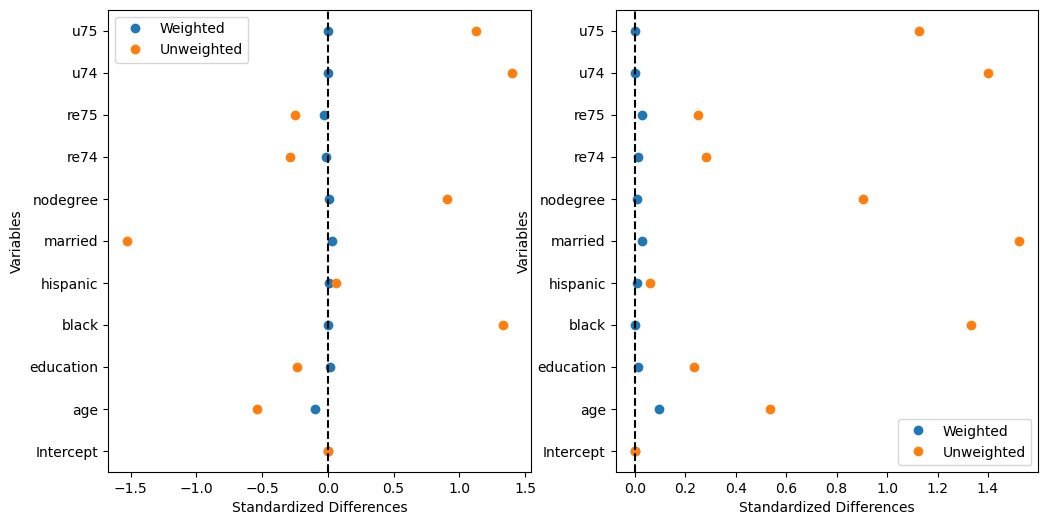

In [22]:
# Set up colnames if you want
col_names = ["Intercept"] + df.drop(columns=["treat", "re78"]).columns.tolist()

f, ax = plt.subplots(1, 2, figsize=(12, 6))
cbps.diagnose(method="smd", ax = ax[0], column_names=col_names)
cbps.diagnose(method="asmd", ax = ax[1], column_names=col_names)

### An example with LR step decay

Optimizing CBPS...: 100%|██████████| 10000/10000 [00:03<00:00, 2977.17it/s]


<Axes: xlabel='Iterations', ylabel='Learning Rate'>

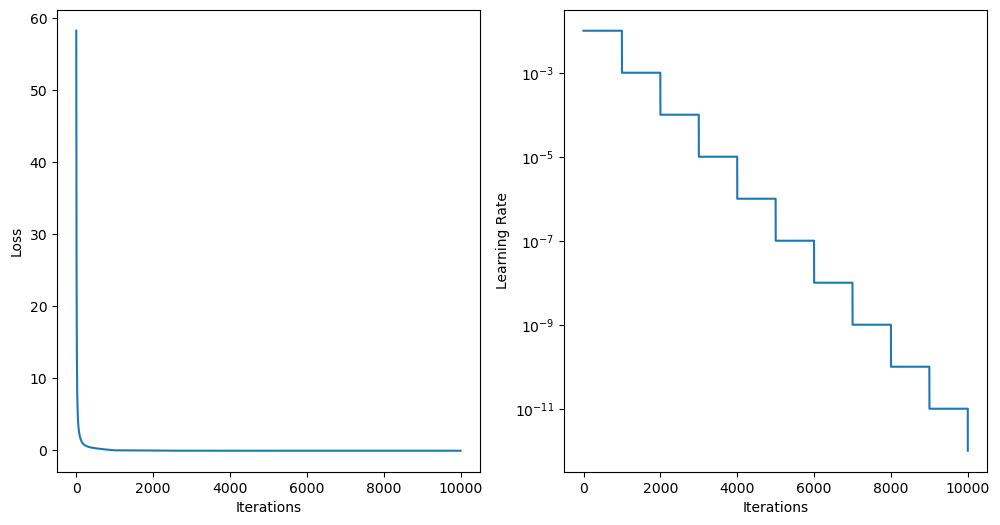

In [47]:
cbps = CBPS(
    X=X,
    W=w,
    estimand="ATT",
    intercept=True,
    noi=False,
    niter=10000,
    lr=0.01,
    reg=1e-5,
    svd=None,
    scheduler=True
)
weights = cbps.weights(numpy=True)

f, ax = plt.subplots(1, 2, figsize=(12, 6))
cbps.diagnose_loss(ax = ax[0], logscale=False)
cbps.diagnose_loss(ax = ax[1], only_lr=True)

## High Dimensional Case

In [23]:
from sklearn.preprocessing import PolynomialFeatures

w, y = df.treat.values, df.re78.values

X = df.drop(columns=["treat", "re78"]).values
X = MinMaxScaler().fit_transform(X)
X = PolynomialFeatures(degree=2).fit_transform(X)

In [24]:
cbps = CBPS(
    X=X,
    W=w,
    estimand="ATT",
    intercept=True,
    noi=False,
    niter=10_000,
    lr=1e-2,
    reg=1e-5,
    svd=None,
)
weights = cbps.weights(numpy=True)

Optimizing CBPS...:   0%|          | 0/10000 [00:00<?, ?it/s]

Optimizing CBPS...: 100%|██████████| 10000/10000 [00:03<00:00, 2928.05it/s]


In [25]:
y[w == 1].mean() - np.average(y[w == 0], weights=weights)

2395.7756449064245

<Axes: xlabel='Unweighted Standardized Differences', ylabel='Weighted Standardized Differences'>

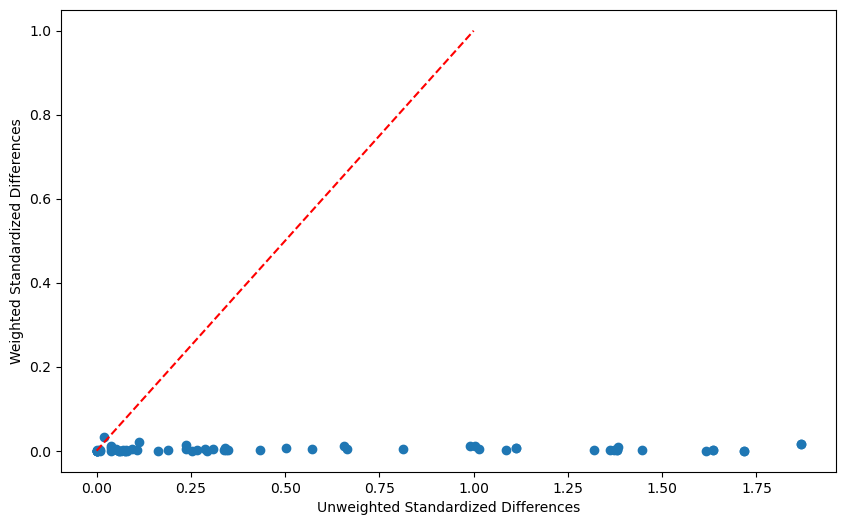

In [26]:
cbps.diagnose(method="asmd", scatter=True)